# Benign or not?

## Predicting the incidence of breast cancer diagnosis using multiple cytological characteristics

### Kyle Willett (12 Jul 2016)



This project focuses on analyzing results of a study measuring several different physical characteristics of a tumor, and then building a classifier to predict whether the tumor is ultimately benign (good for the patient) or malignant (bad). The data were originally collected from a study at the University of Wisconsin and retrieved from the [Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29) at UC Irvine.

The data schema are described in detail on the UCI site. The dataset is a single file containing 699 rows, each corresponding to properties of a tumor measured in a particular patient. For each row (instance), there is a (presumably) random ID, nine attributes that measure properties of the tumor, and a class label that indicates whether the tumor was benign or malignant. Each of the nine attributes is scaled to be an integer between [1,10]. The goal is to use the values of these attributes to predict the class. 

[Wolberg & Mangasarian (1990)](http://www.pnas.org/content/87/23/9193) achieved an accuracy of 93.5% using two pairs of parallel hyperplanes to separate the data. Our minimum goal is to improve upon that benchmark. 

## Initial inspection and plotting

In [1]:
# Load some basic plotting and data analysis packages from Python

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns;

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The original data set had 16 rows with at least one missing attribute (designated as "?") in the data. These instances included 14 benign and 2 malignant tumors, which is a significantly different ratio than the roughly 65%-35% distribution of benign-to-malignant classifiers over the entire dataset. This could be an indicator that missing experimental values are correlated with the class label. 

Since this is a very small fraction of the total dataset (16/699 = 2.2%), the dataset used in this notebook simply eliminates any row where "?" appears. 

In [2]:
# Read in the cleaned dataset as a pandas dataframe.

names = ["sample", "clump_thickness", "uniformity_size", "uniformity_shape", 
         "adhesion", "single_epithelial", "bare_nuclei", "bland_chromatin", 
         "normal_nucleoli", "mitoses", "class"]

data = pd.read_csv("../dc/breast-cancer-wisconsin-cleaned.data",names=names)

As an initial look, let's plot the data using a version of the [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/api.html) plotting package. Since there are nine attributes, this plots each against each other to visualize the relative correlations. 

Plots in the lower left of the grid are 2-D kernel-density estimates (KDE), which show a smoothed version of the relationship between the attributes. Plots in the upper right show the same data as a scatter plot; this is more difficult to interpret since each value can only be an integer from 1 to 10 and most of the points overlap. The plots along the diagonal show both a histogram and a 1-D KDE of each distribution. 

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


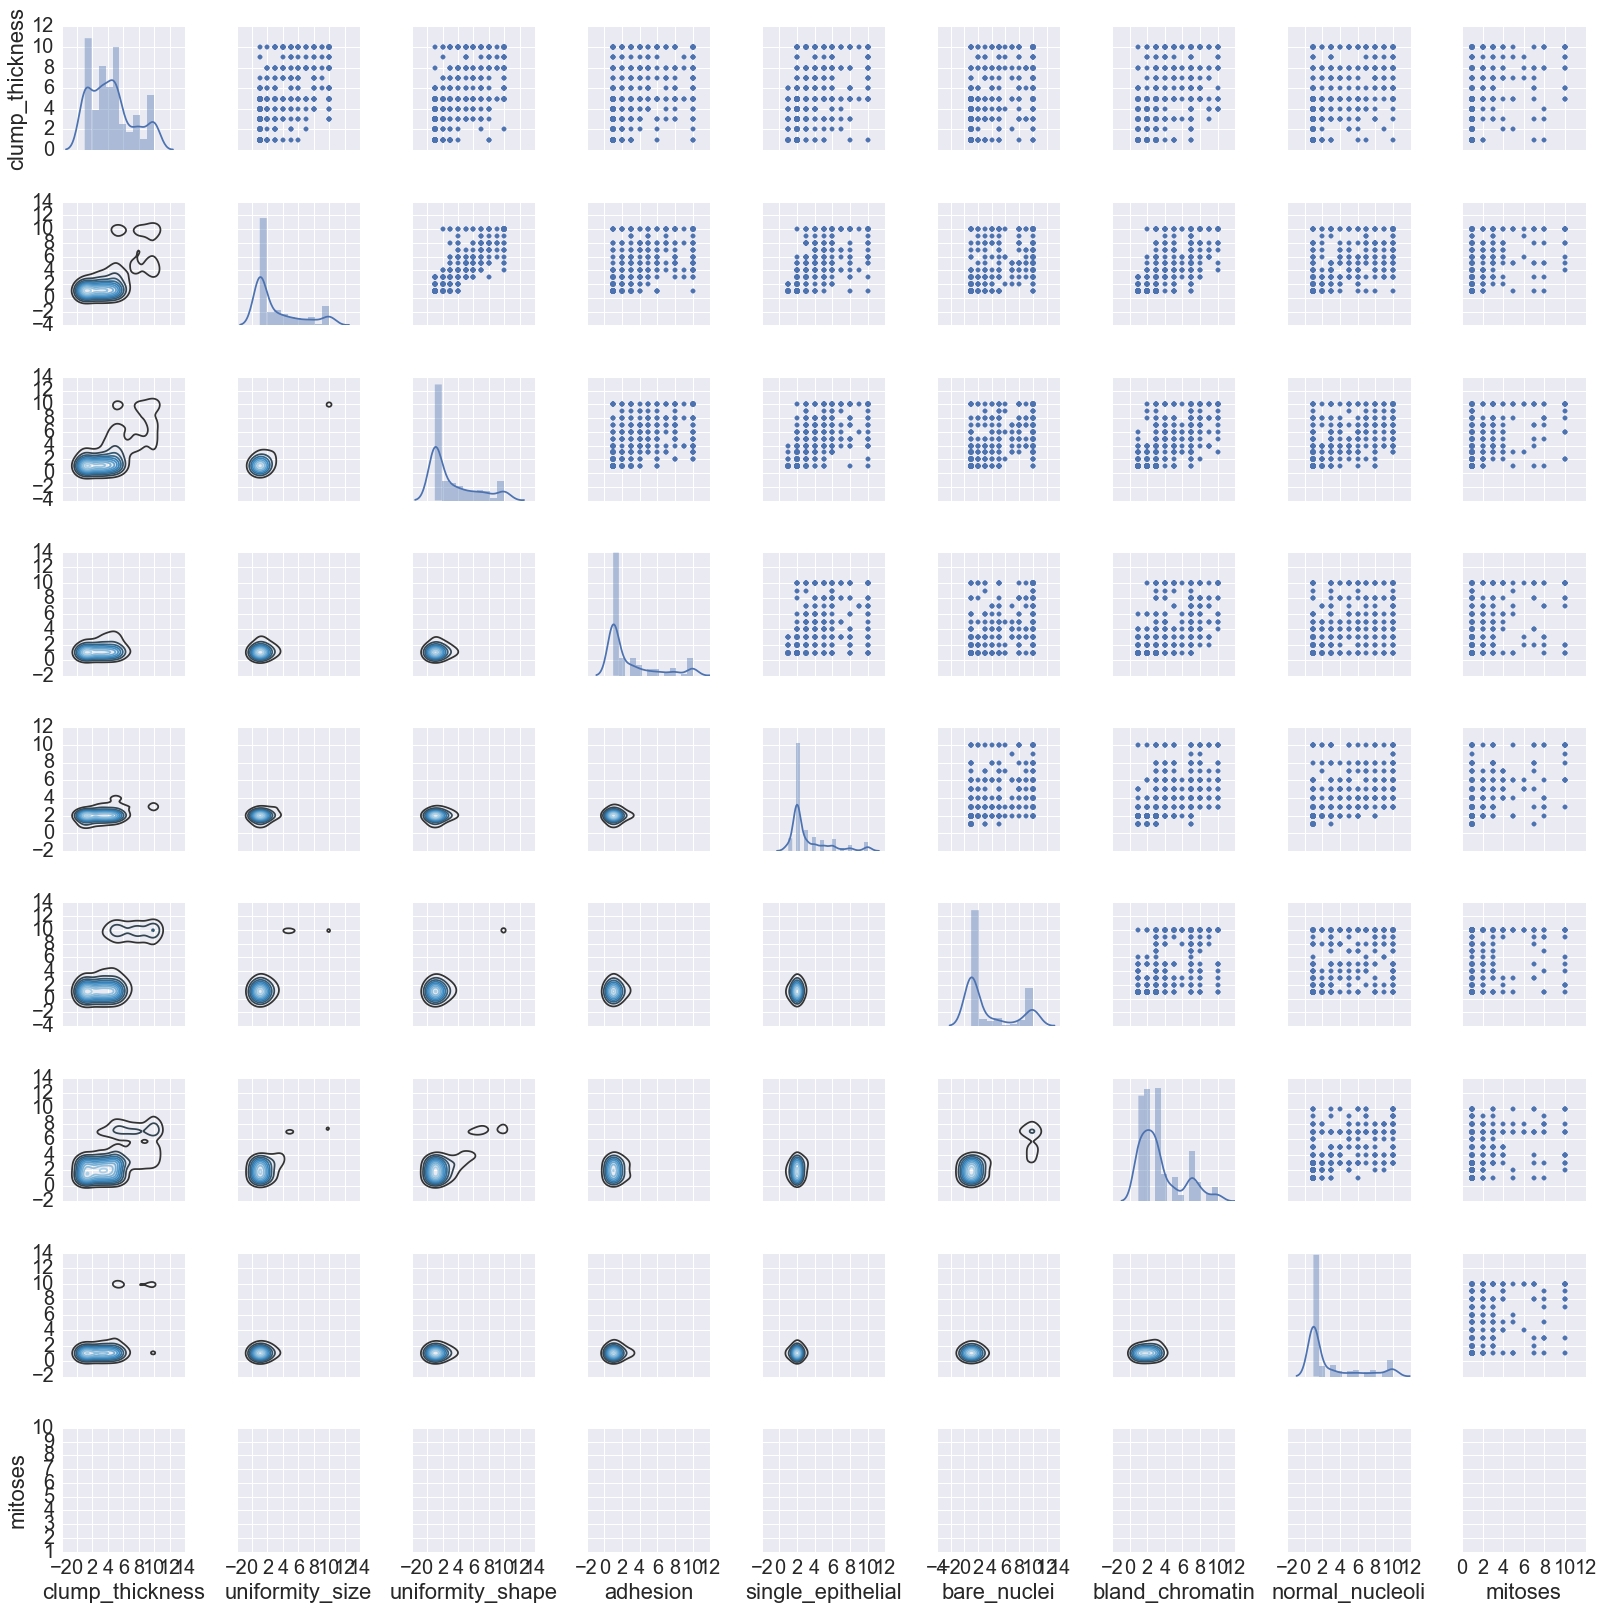

In [3]:
# Plot the relationships in the full dataset on a large grid

with sns.plotting_context("notebook", font_scale=2):
    g = sns.PairGrid(data[names[1:-1]], diag_sharey=False)
    try:
        g.map_lower(sns.kdeplot, cmap="Blues_d",dropna=True)
    except ValueError:
        pass
    try:
        g.map_upper(plt.scatter)
    except ValueError:
        pass
    try:
        g.map_diag(sns.distplot)
    except ValueError:
        pass

The plot above shows the relationships between all attributes (with the exception of the `mitoses` vector, which had undetermined mathematical issues measuring a unique KDE). Looking along the diagonals, most of the attributes are relatively unbalanced, having the majority of their values $\leq 2$. The exceptions are `clump_thickness` and `bland_chromatin`, which have higher fractions of values $>5$.  

## Creating a classifier

[Selection of an estimator](http://scikit-learn.org/stable/tutorial/machine_learning_map/) is done in part by assessing the traits of the dataset and the desired predictions. The ultimate goal is to predict categorical data (benign or malignant), so regression models aren't appropriate. The data are pre-labeled with their class, so clustering isn't necessary. The total amount of data is $\lesssim1000$ samples, so a simple implementation of a support vector machine classifier (SVC) will be able to handle it. 

SVCs should be useful because they can classify high-dimensional data ($N=9$ here) and have a number of different parameters that can be optimized for the kernel function. The probability estimates for each class can be estimated later using $k$-fold cross-validation. 

In [4]:
# Import the modules for the SVM from scikit-learn

import numpy as np
from sklearn.svm import LinearSVC
from sklearn import cross_validation

In [5]:
"""Load the data

SVM expects the attributes to be an array in the shape (N,M)
and the labels as an array with shape (N,)
where N = number of rows (samples)
and M = number of attributes
"""

X = np.array(data[names[1:-1]])  
y = np.array(data[['class']]).ravel()

### Simple training/test split at 40%

To avoid overfitting the model, the data are split into a training sample on which the model is fit and a test sample on which it is evaluated. This begins with a 60%-40% split for the test and training data. 

In [6]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=1)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(409, 9) (409,)
(274, 9) (274,)


So there are 409 samples in the training data and 274 in the test data. Now let's fit the model to the training data and assess the accuracy on the test. 

In [7]:
clf = LinearSVC(C=1).fit(X_train, y_train)
print("Accuracy: %0.2f" % clf.score(X_test, y_test))

Accuracy: 0.97


This is excellent; without any fine-tuning, our 97% accuracy exceeds the initial benchmark of 93% from the published paper.

### Cross-validate

To do a better job of assessing the model accuracy than just using a single training-test split (which could be biased), cross-validation can be used to run the same comparison many times using different splits. The implementation below runs 5-fold validation; the variance between the results gives an estimate on the uncertainty of the accuracy.

In [8]:
clf = LinearSVC(C=1)
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.97 (+/- 0.02)


This is a very close result to the single test above, indicating that the initial split was fairly unbiased. 

### Parameter estimation through grid search

This is initially a good result, but can be fine-tuned. The SVM has several parameters that control the features of the separating hyperplanes, including the nature of the kernel, the kernel coefficient, and the penalty parameter of the error term. These can be optimized to provide a better fit. 

To prevent from overfitting through optimization, the data set are now split into three sets: training, test, and validation. The SVM parameters will be optimized on the training and test sets and the accuracy evaluated on the validation set. 

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [10]:
"""tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
"""

# Limit to a linear kernel; this will allow relative ranking of
# the features
tuned_parameters = [{'C': np.logspace(-2,0,25)}]

scores = ['precision', 'recall']

for score in scores:
    print("\nTuning hyper-parameters for %s" % score)
    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    
best_params = clf.best_params_


Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 0.026101572156825358}

Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 0.026101572156825358}


Tuning the parameters in the grid can attempt to optimize different predictive value; the grid above examines both precision and recall. For this particular dataset, the best parameters are the same no matter which one is optimized, which is useful. The overall accuracy is still the same as the initial run. 

In [47]:
# Test again with the new parameters and cross-validation

clf = LinearSVC(C=best_params['C']).fit(X_train,y_train)
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.96 (+/- 0.03)


### Results

In [48]:
benign_test = X_test[y_test == 2]
malignant_test = X_test[y_test == 4]
n = len(X_test)

predicted_benign = clf.predict(benign_test)
predicted_malignant = clf.predict(malignant_test)

print "True positive rate: {}/{}".format(sum(predicted_benign == 2),len(benign_test))
print "True negative rate: {}/{}".format(sum(predicted_malignant == 4),len(malignant_test))
print "\nFalse positive rate: {}/{} ({:.1f}% of all cases)".format(
    sum(predicted_benign == 4),len(benign_test),sum(predicted_benign == 4)/float(n)*100.)
print "False negative rate: {}/{} ({:.1f}% of all cases)".format(
    sum(predicted_malignant == 2),len(malignant_test),sum(predicted_malignant == 2)/float(n)*100.)

True positive rate: 175/178
True negative rate: 92/96

False positive rate: 3/178 (1.1% of all cases)
False negative rate: 4/96 (1.5% of all cases)


The new model predicts breast cancer with 96% accuracy. However, the number of incorrect tests is unequally distributed; false positives (saying the patient has cancer when they do not) is expected in ~1.1% of all cases. False negatives (saying the patient is healthy when they in fact have cancer) occur in ~1.5% of cases.

False negatives are presumably much worse than false positives for several reasons; a test is likely to be repeated for a human with a malignant tumor, whereas it would be inefficient and expensive to retest samples for the larger population of negative results. The consequences of beginning treatment for a non-existent disease are also presumably much worse than suffering from a known but undiagnosed disease. 

Improving the model therefore should emphasize bringing down the false negative rate as much as possible. 